In [1]:
from IPython import display
def dhtml(st):
    display.display(display.HTML("""<style>
    @import url('https://fonts.googleapis.com/css?family=Roboto|Orbitron&effect=3d');      
    </style><p class='font-effect-3d' onclick='setStyle(this,"#ff6600")'
    style='font-family:Roboto; font-size:25px; color:#ff355e;'>
    %s</p>"""%st+"""<script>
    function setStyle(element,c) {
     var docs=document.getElementsByClassName('font-effect-3d');
     for (var i=0; i<docs.length; i++) {
         docs[i].style='font-family:Orbitron; font-size:22px;'; 
         docs[i].style.color=c;}; };
    </script>"""))
dhtml('Code Modules & Parameters')

In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-nabjb5g3
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-nabjb5g3
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0cc14a8a40d1bddf8f3b04c908c94d69e9d8addce_-py3-none-any.whl size=113998 sha256=0d92f870110ac06f8359b8f0a3be842764e35691d16c90325215459a843f726d
  Stored in directory: /tmp/pip-ephem-wheel-cache-4u1o0z75/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import numpy as np,pylab as pl,pandas as pd
import h5py,imageio,PIL
import tensorflow as tf
import tensorflow_hub as th
from tensorflow_docs.vis import embed

In [4]:
seed_size=16; noise_dim=784; epochs=100
buffer_size=60000; batch_size=256
norm_img=tf.random.normal([1,noise_dim])
seed_imgs=tf.random.normal([seed_size,noise_dim])

In [5]:
dhtml('Data')

In [6]:
(x,y),(_, _)=tf.keras.datasets.mnist.load_data()
x=x.reshape(x.shape[0],28,28,1).astype('float32')
x=(x-127.5)/127.5
digits=tf.data.Dataset.from_tensor_slices(x)\
.shuffle(buffer_size).batch(batch_size)

11493376/11490434 [==============================] - 0s 0us/step


In [7]:
dhtml('Deep Convolutional Generative Adversarial Network')

In [8]:
def tfgenerator():
    model=tf.keras.Sequential()
    model.add(tf.keras.layers\
    .Dense(7*7*256,use_bias=False,input_shape=(noise_dim,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((7,7,256)))
    model.add(tf.keras.layers\
    .Conv2DTranspose(256,(5,5),strides=(1,1),
                     padding='same',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers\
    .Conv2DTranspose(16,(5,5),strides=(2,2),
                     padding='same',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers\
    .Conv2DTranspose(1,(5,5),strides=(2,2),
                     padding='same',use_bias=False,
                     activation='tanh'))
    return model
tfgenerator=tfgenerator()

In [9]:
def tfdiscriminator():
    model=tf.keras.Sequential()
    model.add(tf.keras.layers\
    .Conv2D(16,(5,5),strides=(2,2),
            padding='same',input_shape=[28,28,1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(.2))
    model.add(tf.keras.layers\
    .Conv2D(256,(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model
tfdiscriminator=tfdiscriminator()

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.01049905]], dtype=float32)>

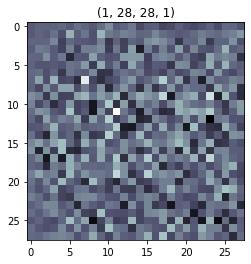

In [10]:
generated_img=tfgenerator(norm_img,training=False)
pl.imshow(generated_img[0,:,:,0],cmap=pl.cm.bone)
pl.title(generated_img.shape)
tfdiscriminator(generated_img)

In [11]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output,fake_output):
    real_loss=cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss=real_loss+fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)
checkpoint=tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                               generator=tfgenerator,
                               discriminator=tfdiscriminator)

In [12]:
dhtml('Training')

In [13]:
@tf.function
def train_step(imgs):
    random_imgs=tf.random.normal([batch_size,noise_dim])
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_imgs=tfgenerator(random_imgs,training=True)
        real_output=tfdiscriminator(imgs,training=True)
        fake_output=tfdiscriminator(generated_imgs,training=True)
        gen_loss=generator_loss(fake_output)
        disc_loss=discriminator_loss(real_output,fake_output)
        gradients_of_generator=\
        gen_tape.gradient(gen_loss,tfgenerator.trainable_variables)
        gradients_of_discriminator=\
        disc_tape.gradient(disc_loss,tfdiscriminator.trainable_variables)
        generator_optimizer\
        .apply_gradients(zip(gradients_of_generator,
                             tfgenerator.trainable_variables))
        discriminator_optimizer\
        .apply_gradients(zip(gradients_of_discriminator,
                             tfdiscriminator.trainable_variables))

In [14]:
def generate_images(model,epoch,test_input):
    predictions=model(test_input,training=False)
    fig=pl.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        pl.subplot(4,4,i+1)
        pl.imshow(predictions[i,:,:,0]*127.5+127.5,
                  cmap=pl.cm.bone)
        pl.axis('off')
    pl.savefig('epoch_{:04d}.png'.format(epoch+1))
    pl.suptitle('Epoch: %04d'%(epoch+1),
                color='#ff355e',fontsize=20)
    pl.show()

In [15]:
def train(data,epochs):
    for epoch in range(epochs):
        for image_batch in data:
            train_step(image_batch)
#            display.clear_output(wait=True)
#            generate_images(tfgenerator,epoch+1,seed_imgs)
        if (epoch+1)%10==0:
            generate_images(tfgenerator,epoch,seed_imgs)
#            checkpoint.save(file_prefix='')
#            display.clear_output(wait=True)
#            generate_images(tfgenerator,epochs,seed_imgs)

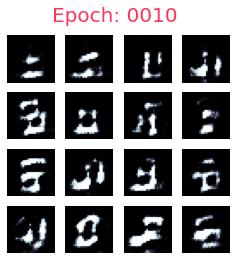

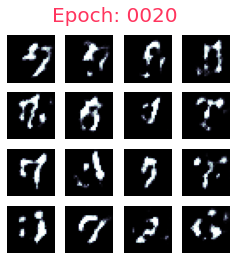

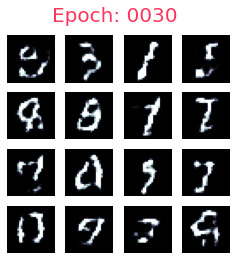

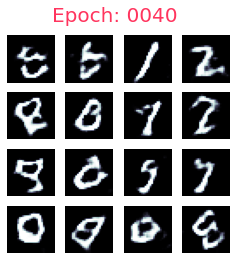

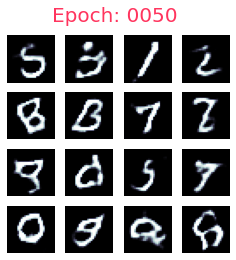

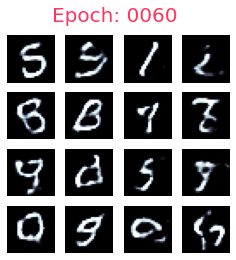

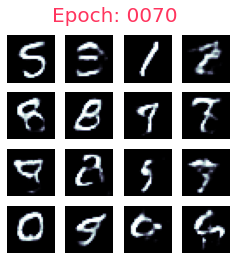

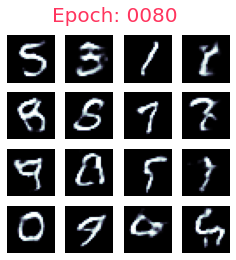

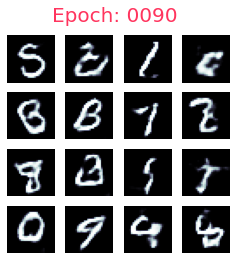

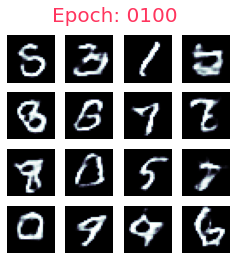

In [16]:
train(digits,epochs)

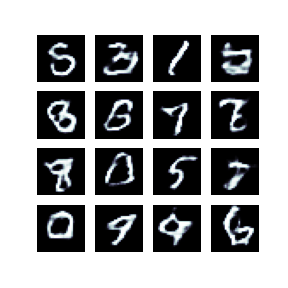

In [17]:
PIL.Image.open('epoch_{:04d}.png'.format(epochs))

In [18]:
dhtml('Interpolation')

In [19]:
def animate(images):
    converted_images=np.clip(images*255,0,255)\
    .astype(np.uint8)
    imageio.mimsave('animation.gif',converted_images)
    return embed.embed_file('animation.gif')

In [20]:
def interpolate_hypersphere(v1,v2,steps):
    v1norm=tf.norm(v1)
    v2norm=tf.norm(v2)
    v2normalized=v2*(v1norm/v2norm)
    vectors=[]
    for step in range(steps):
        interpolated=v1+(v2normalized-v1)*step/(steps-1)
        interpolated_norm=tf.norm(interpolated)
        interpolated_normalized=\
        interpolated*(v1norm/interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)

In [21]:
def interpolate_between_vectors(steps):
    tf.random.set_seed(1)
    v1=tf.random.normal([noise_dim])
    v2=tf.random.normal([noise_dim])
    vectors=interpolate_hypersphere(v1,v2,steps)
    interpolated_imgs=tfgenerator(vectors,training=False)
    interpolated_imgs=\
    tf.image.resize(interpolated_imgs,[128,128])
    return interpolated_imgs


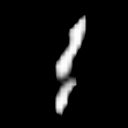

In [22]:
imgs=interpolate_between_vectors(120)
animate(imgs)
